In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth',-1)

sns.set_style("whitegrid")
sns.set_context('notebook')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (14,6)

In [3]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data
#from preprocess.build_features import remove_invalid_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from data.make_dataset import load_stif,build_nb

In [83]:
df = pd.read_feather('../data/processed/nb-validation-2017.feather')

## Quick look

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654978 entries, 0 to 654977
Data columns (total 5 columns):
kind     654978 non-null object
date     654978 non-null datetime64[ns]
stop     654978 non-null object
value    654978 non-null int64
sem      654978 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 25.0+ MB


In [7]:
df.describe()

,value
count,654978.000000
mean,1513.947806
std,3614.809873
min,5.000000
25%,121.000000
50%,313.000000
75%,1193.000000
max,115600.000000


In [8]:
df.head()

,kind,date,stop,value,sem
0,AUTRE TITRE,2017-03-17,BARBES-ROCHECHOUART,349,S1-2017
1,NAVIGO,2017-03-17,MAIRIE DE MONTREUIL,16509,S1-2017
2,IMAGINE R,2017-03-17,MAIRIE DE SAINT-OUEN,1807,S1-2017
3,AUTRE TITRE,2017-03-17,MAIRIE DES LILAS,172,S1-2017
4,TST,2017-03-17,MAIRIE DES LILAS,542,S1-2017


In [9]:
df.date.min()

Timestamp('2017-01-01 00:00:00')

In [10]:
df.date.max()

Timestamp('2017-12-31 00:00:00')

## Monthly traffic

In [11]:
monthly = df.groupby('date').sum().resample('1m').sum()['value']

In [12]:
monthly.index = [elt.month for elt in monthly.index]

Text(0.5,1,'monthly traveler in million')

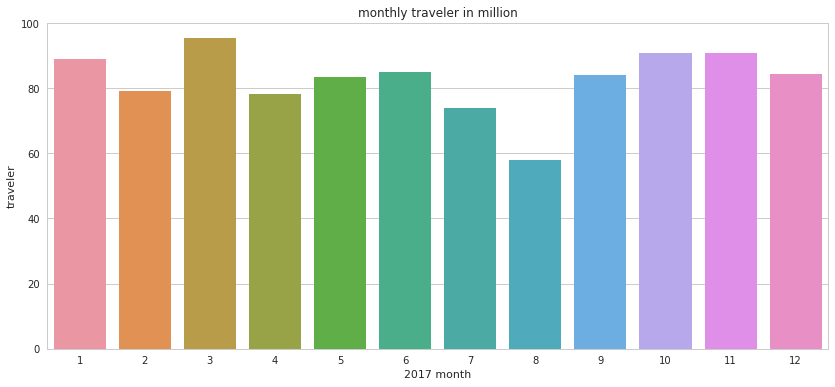

In [13]:
ax= sns.barplot(x=monthly.index,
                y=monthly.div(10**6),
               )
ax.set_xlabel('2017 month')
ax.set_ylabel('traveler')

ax.set_title('monthly traveler in million')


In [14]:
month_pct = monthly.pct_change()

Text(0.5,1,'Change month over month')

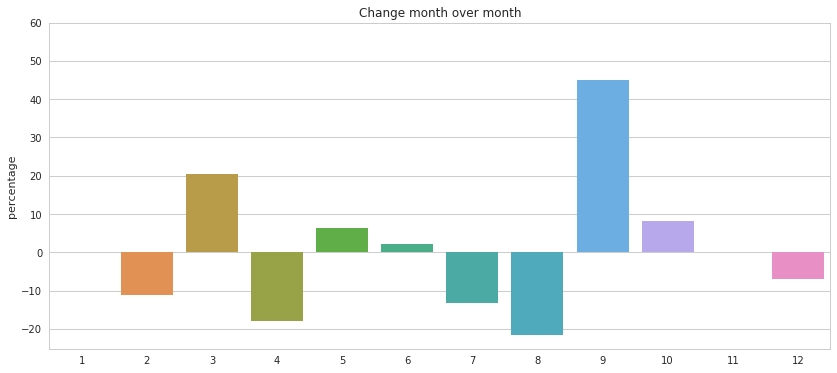

In [15]:
ax= sns.barplot(x=month_pct.index,
                y=month_pct*100,
               )
ax.set_ylim([month_pct.min()-25,60])
ax.set_ylabel('percentage')
ax.set_title('Change month over month')

In [16]:
df.head()

,kind,date,stop,value,sem
0,AUTRE TITRE,2017-03-17,BARBES-ROCHECHOUART,349,S1-2017
1,NAVIGO,2017-03-17,MAIRIE DE MONTREUIL,16509,S1-2017
2,IMAGINE R,2017-03-17,MAIRIE DE SAINT-OUEN,1807,S1-2017
3,AUTRE TITRE,2017-03-17,MAIRIE DES LILAS,172,S1-2017
4,TST,2017-03-17,MAIRIE DES LILAS,542,S1-2017


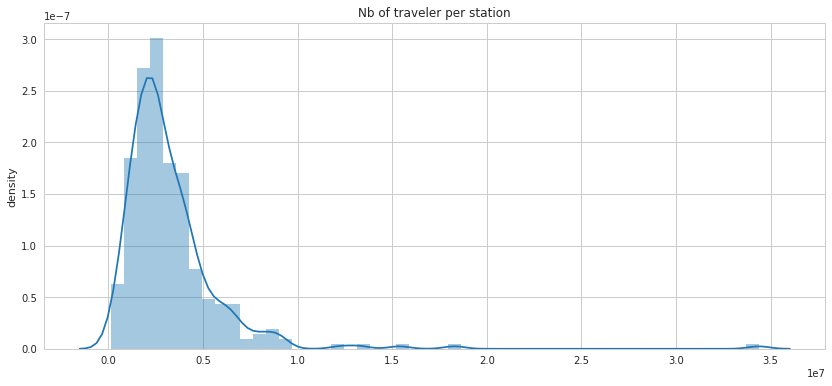

In [17]:
ax = sns.distplot(df.groupby('stop').sum())
ax.set_title('Nb of traveler per station')
x = ax.set_ylabel('density')

## Popular stops

In [18]:
#df.describe()

In [19]:
df.groupby('stop').sum().sort_values('value',ascending=False).head(10)

,value
stop,
SAINT-LAZARE,34376040
MONTPARNASSE,18301940
GARE DE L'EST,15388075
REPUBLIQUE,13268205
LES HALLES,12290650
BASTILLE,9187284
BELLEVILLE,9092300
PLACE D'ITALIE,8931491
BARBES-ROCHECHOUART,8852330


## **Un**Popular stops

In [20]:
df.groupby('stop').sum().sort_values('value',ascending=True).head(10)

,value
stop,
EGLISE D'AUTEUIL,134409
PELLEPORT,283532
PRE SAINT-GERVAIS,297832
BUTTES-CHAUMONT,408055
BOLIVAR,424286
PORTE D'AUTEUIL,433208
DANUBE,498702
CHARDON-LAGACHE,502612
SAINT-FARGEAU,562473


## Improving data

One issue with this approach is that it does not model well the number of people per line and therefore per train.

We should at least take in account the number of line that go through each station

There is a handy dataset published by the STIF that help for that

In [64]:
df_lines = load_stif('../data/raw/lignes.json')[['stop_name','route_short_name','pointgeo']]

In [116]:
df_lines.head()

,stop_name,route_short_name,pointgeo
0,Palais-Royal (Musée du Louvre),1,"[48.862375, 2.336592]"
1,Château de Vincennes,1,"[48.844327, 2.440572]"
2,Bérault,1,"[48.845371, 2.428264]"
3,Pont de Neuilly,1,"[48.88551, 2.258546]"
4,Saint-Mandé,1,"[48.846241, 2.419019]"


In [117]:
df_mapping=(df_lines.groupby('stop_name').count()[['route_short_name']]
 .rename(columns={'route_short_name':'nb_lines'})
 .reset_index()
 .rename(columns={'stop_name':'stop'})
 #to merge easily with other data
 .assign(stop=lambda x : x.stop.str.lower())
)

In [118]:
df.stop = df['stop'].apply(lambda x :x.lower())

In [119]:
df_merged = pd.merge(df,df_mapping,on='stop')

I make the assumption that every line is equally likely to be chosen by a traveler 

Which more or less hold according to this [wikipedia draft](https://fr.wikipedia.org/wiki/Liste_des_lignes_de_m%C3%A9tro_parisiennes_par_fr%C3%A9quentation)

In [102]:
df_merged['normalized'] = df_merged.value.div(df_merged.nb_lines)

In [103]:
df_merged.head()

,kind,date,stop,value,sem,nb_lines,normalized
0,NAVIGO,2017-03-17,mairie de montreuil,16509,S1-2017,1,16509.0
1,AUTRE TITRE,2017-01-01,mairie de montreuil,56,S1-2017,1,56.0
2,AMETHYSTE,2017-06-30,mairie de montreuil,430,S1-2017,1,430.0
3,AUTRE TITRE,2017-06-30,mairie de montreuil,203,S1-2017,1,203.0
4,FGT,2017-06-30,mairie de montreuil,1228,S1-2017,1,1228.0


In [114]:
import numpy as np
(df_merged.groupby('stop').agg({'value':sum,'nb_lines':np.unique})
 .sort_values('value',ascending=False).head(10))

,value,nb_lines
stop,,
saint-lazare,34376040,4
les halles,12290650,1
bastille,9187284,3
belleville,9092300,2
place d'italie,8931491,3
strasbourg-saint-denis,7904836,3
gare du nord,7440791,2
nation,6939254,4
place de clichy,6716027,2


In [113]:
import numpy as np
(df_merged.groupby('stop').agg({'value':sum,'nb_lines':np.unique})
 .sort_values('value',ascending=True).head(10))

,value,nb_lines
stop,,
eglise d'auteuil,134409,1
pelleport,283532,1
buttes-chaumont,408055,1
bolivar,424286,1
porte d'auteuil,433208,1
danube,498702,1
chardon-lagache,502612,1
saint-fargeau,562473,1
botzaris,737641,1


In [ ]:
df.groupby